# Bayesian Belief Network (BBN)

### Step 1 - Import Libraries

In [1]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

# Other utilities
import sys
import os

# Assign main directory to a variable
main_dir=os.path.dirname(sys.path[0])

### Step 2 - Get the Australian weather data for our model (from Kaggle)
- Donwload from: https://www.kaggle.com/jsphyg/weather-dataset-rattle-package
- After downloading it, we read csv into a Pandas dataframe

In [2]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv(main_dir+'/data/weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create a flag for RainTomorrow, note RainTomorrowFlag will be our target variable
#df['RainTomorrowFlag']=df['RainTomorrow'].apply(lambda x: 1 if x=='Yes' else 0)

# Creates bands for variables that we want to use in the model
#df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '1.>50' if x>50 else '0.<=50')
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustSpeedCat,Humidity9amCat,Humidity3pmCat
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,1.40-50,1.>60,0.<=60
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,1.40-50,0.<=60,0.<=60
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,1.40-50,0.<=60,0.<=60
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,0.<=40,0.<=60,0.<=60
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,1.40-50,1.>60,0.<=60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No,0.<=40,0.<=60,0.<=60
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No,0.<=40,0.<=60,0.<=60
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No,0.<=40,0.<=60,0.<=60
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No,0.<=40,0.<=60,0.<=60


### Step 3 - Define Functions

##### This function helps to calculate probabily distribution, which goes into BBN (note, limited to max 2 parents)

In [3]:
def probs(data, child, parent1=None, parent2=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        prob=data[child].value_counts(normalize=True, sort=False).sort_index().tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Work out the bands present in the parent variable
                bands=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val in bands:
                    temp=data[data[parent1]==val][child].value_counts(normalize=True).sort_index().tolist()
                    prob=prob+temp
            else:    
                # Work out the bands present in the parent variable
                bands1=df[parent1].value_counts(sort=False).sort_index().index.tolist()
                bands2=df[parent2].value_counts(sort=False).sort_index().index.tolist()
                # Caclucate probabilities
                for val1 in bands1:
                    for val2 in bands2:
                        temp=data[(data[parent1]==val1) & (data[parent2]==val2)][child].value_counts(normalize=True).sort_index().tolist()
                        prob=prob+temp
    else: print("Error in Probability Frequency Calculations")
    return prob            

##### This is a second version of the function that also works with missing permutations

In [4]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs_v2(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

### Step 4 - Set up BBN

In [5]:
# Create nodes by manually typing in probabilities
#H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), [43594, 98599])
#H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), [0.30658, 0.69342])
#H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), [0.92827, 0.07173, 
#                                                      0.55760, 0.44240])
#W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), [0.58660, 0.24040, 0.17300])
#RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), [0.92314, 0.07686, 
#                                                0.89072, 0.10928, 
#                                                0.76008, 0.23992, 
#                                                0.64250, 0.35750, 
#                                                0.49168, 0.50832, 
#                                                0.32182, 0.67818])


# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs_v2(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs_v2(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs_v2(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs_v2(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)

##### Draw a network diagram

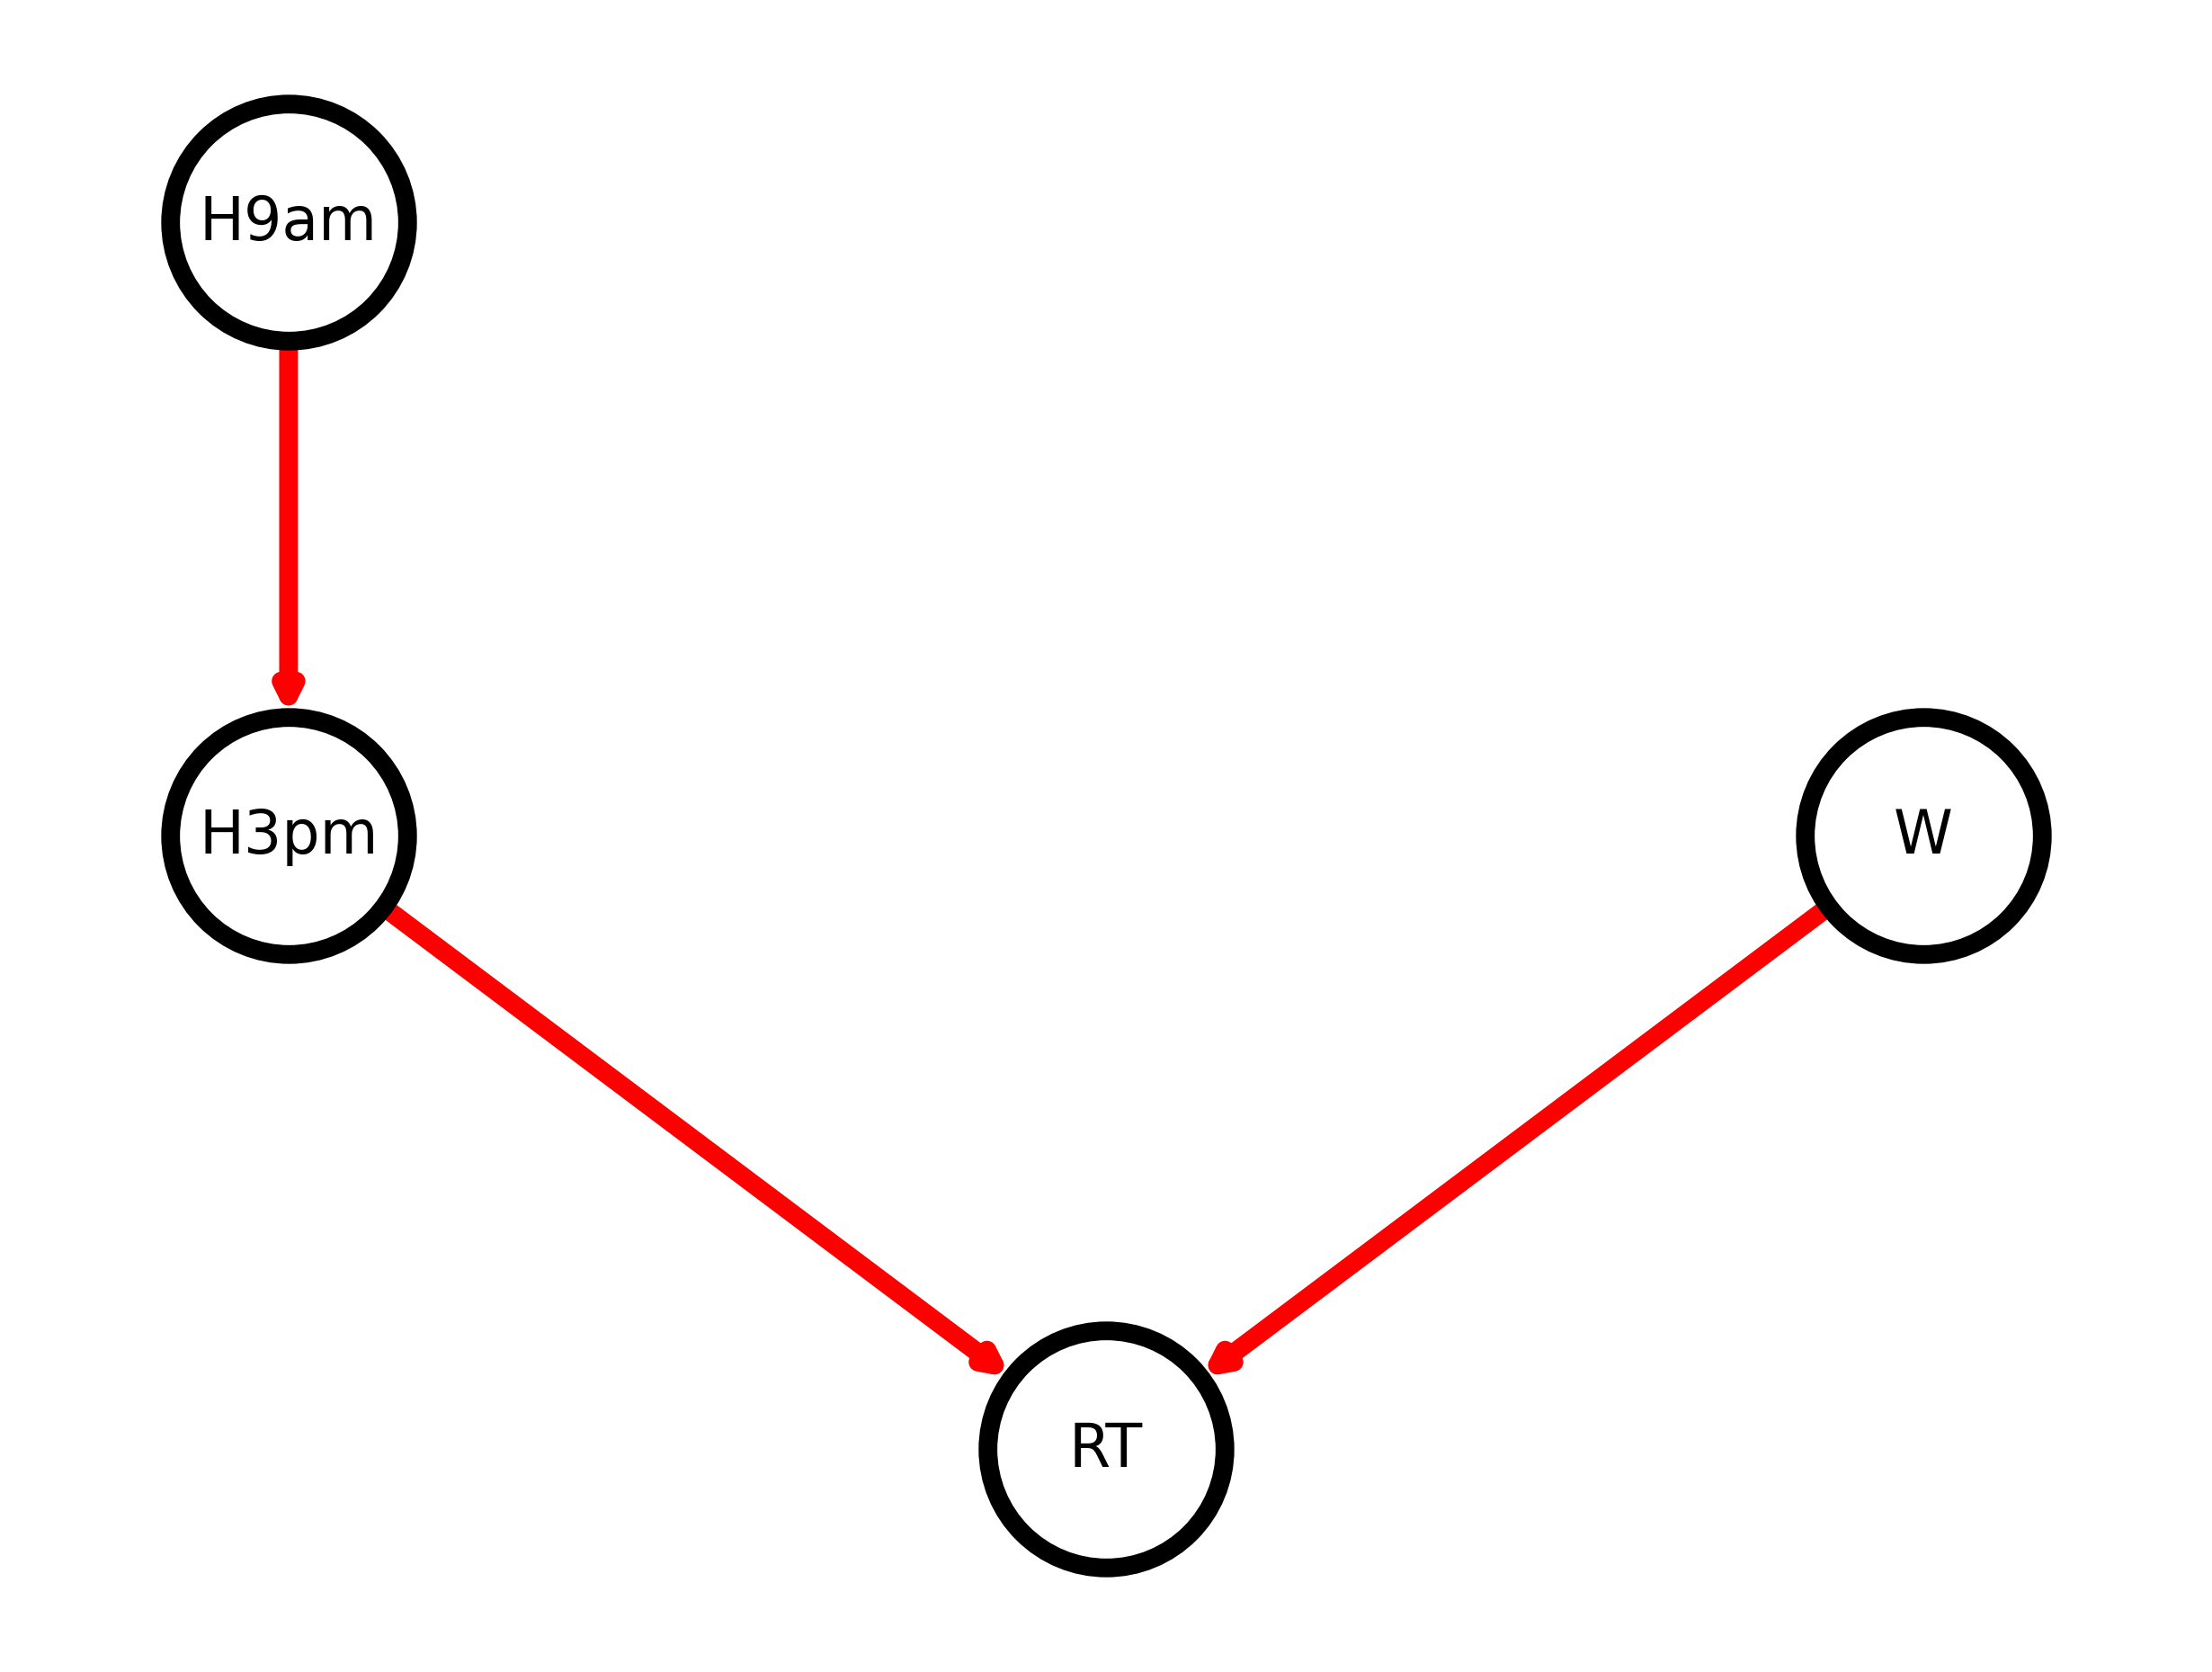

In [6]:
# Print BBN Graph
plt.figure(figsize=(8,6), dpi=300)
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

##### Set up a couple more functions

In [7]:
def print_probs():
    # Print marginal probabilities
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')

In [8]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)

In [9]:
# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


##### Results with probs_v2

In [10]:
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


##### Add event evidence to recalculate probabilities
- To add evidence run below. To remove evidence just run the same code one more time

In [11]:
# Add evidence
evidence('ev1', 'H3pm', '>60', 1.0)
evidence('ev2', 'W', '>50', 1.0)
#evidence(ev2, 'W', '>50', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.06689
0=>60|0.93311
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------


# END of Program